HybridV2 (ResNet50 with LSTM)

In [1]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, LSTM, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

Check Image Corruption

In [2]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Total corrupted images: 0


In [3]:
# def preprocess_image(image_path, size=(224, 224)):
#     try:
#         img = Image.open(image_path)
        
#         # Quality enhancement
#         enhancer = ImageEnhance.Sharpness(img)
#         img = enhancer.enhance(2.0)  # Increase sharpness
        
#         # Noise reduction
#         image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
#         image = cv2.GaussianBlur(image, (5, 5), 0)
#         img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
#         # Consistency
#         img = img.resize(size, Image.LANCZOS)

#         # Normalization
#         img_array = np.array(img) / 255.0
    
#         # Convert back to image
#         img = Image.fromarray((img_array * 255).astype(np.uint8))
        
#         return img
#     except (UnidentifiedImageError, IOError) as e:
#         print(f"Error processing image {image_path}: {e}")
#         return None

# input_dir = 'images_train_test_val/train'
# output_dir = 'processed_images'

# # Apply preprocessing and save to new directory
# for category in os.listdir(input_dir):
#     category_path = os.path.join(input_dir, category)
#     if os.path.isdir(category_path):
#         output_category_path = os.path.join(output_dir, category)
#         if not os.path.exists(output_category_path):
#             os.makedirs(output_category_path)
#         for image_name in os.listdir(category_path):
#             image_path = os.path.join(category_path, image_name)
#             preprocessed_img = preprocess_image(image_path)
#             if preprocessed_img:
#                 preprocessed_img.save(os.path.join(output_category_path, image_name))


In [4]:
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [5]:
def create_hybrid_model_v2(optimizer='adam', init_mode='uniform', l2_rate=0.01, learning_rate=0.0001):
    base_model = ResNet50(include_top=False, 
                          weights='imagenet', 
                          input_tensor=Input(shape=(224, 224, 3)))
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Adding Dense layers before LSTM
    x = Dense(512, activation='relu', kernel_initializer=init_mode, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Reshape for LSTM
    x = Reshape((1, 512))(x)
    x = LSTM(256, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    
    predictions = Dense(21, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers[:-30]:  # Only fine-tune the top layers
        layer.trainable = False
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Compile and train the model as before
model = create_hybrid_model_v2()

2024-07-25 03:41:20.514573: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-25 03:41:20.514654: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-25 03:41:20.514695: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-25 03:41:20.515065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-25 03:41:20.515106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
import json
import os

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path
        # Create the file initially or clear existing file
        if not os.path.exists(file_path):
            with open(file_path, 'w') as f:
                json.dump({}, f)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        with open(self.file_path, 'r+') as f:
            history = json.load(f)
            for key, value in logs.items():
                if key in history:
                    history[key].append(value)
                else:
                    history[key] = [value]
            f.seek(0)  # Go to the beginning of the file
            json.dump(history, f, indent=4)

In [7]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'models/best_HybridV2_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='min',
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping, SaveHistoryCallback('models/HybridV2_history.json')],
)


Epoch 1/20


2024-07-25 03:41:25.222091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1344 - loss: 11.4215
Epoch 1: val_loss improved from inf to 9.79469, saving model to models/best_HybridV2_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.1348 - loss: 11.4152 - val_accuracy: 0.0610 - val_loss: 9.7947
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3005 - loss: 8.7249
Epoch 2: val_loss improved from 9.79469 to 7.48271, saving model to models/best_HybridV2_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.3007 - loss: 8.7202 - val_accuracy: 0.2410 - val_loss: 7.4827
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3807 - loss: 6.7522
Epoch 3: val_loss improved from 7.48271 to 6.01293, saving model to models/best_HybridV2_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.3807 - loss: 6.7491 - val_accuracy: 0.2676 - val_loss: 6.0129
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4199 - loss: 5.3496
Epoch 4: val_los

In [8]:
# Evaluate the model
model = tf.keras.models.load_model('models/best_HybridV2_model.keras')
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4871 - loss: 2.0723
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4518 - loss: 2.2059
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5119 - loss: 2.0781
Train accuracy: 0.4831, Validation accuracy: 0.4586, Test accuracy: 0.4952


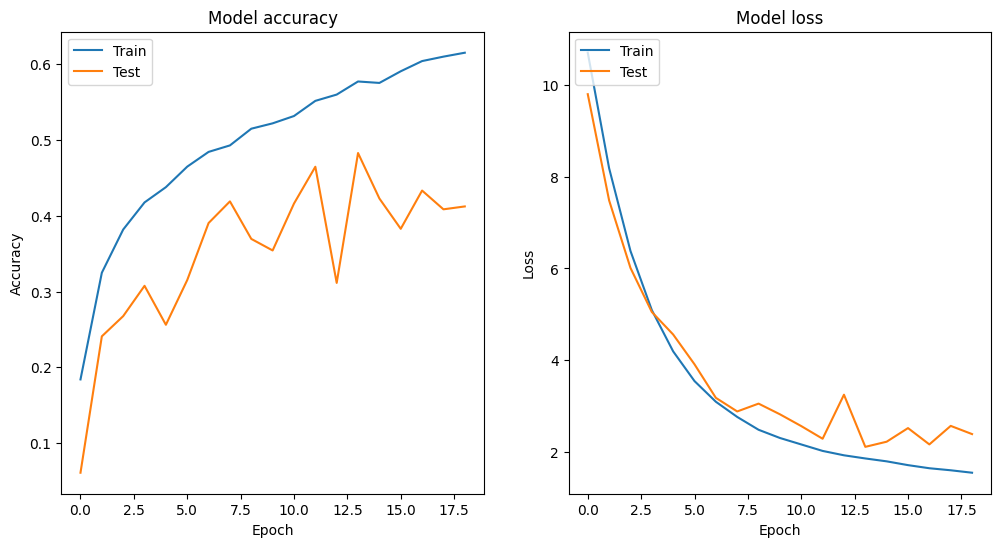

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


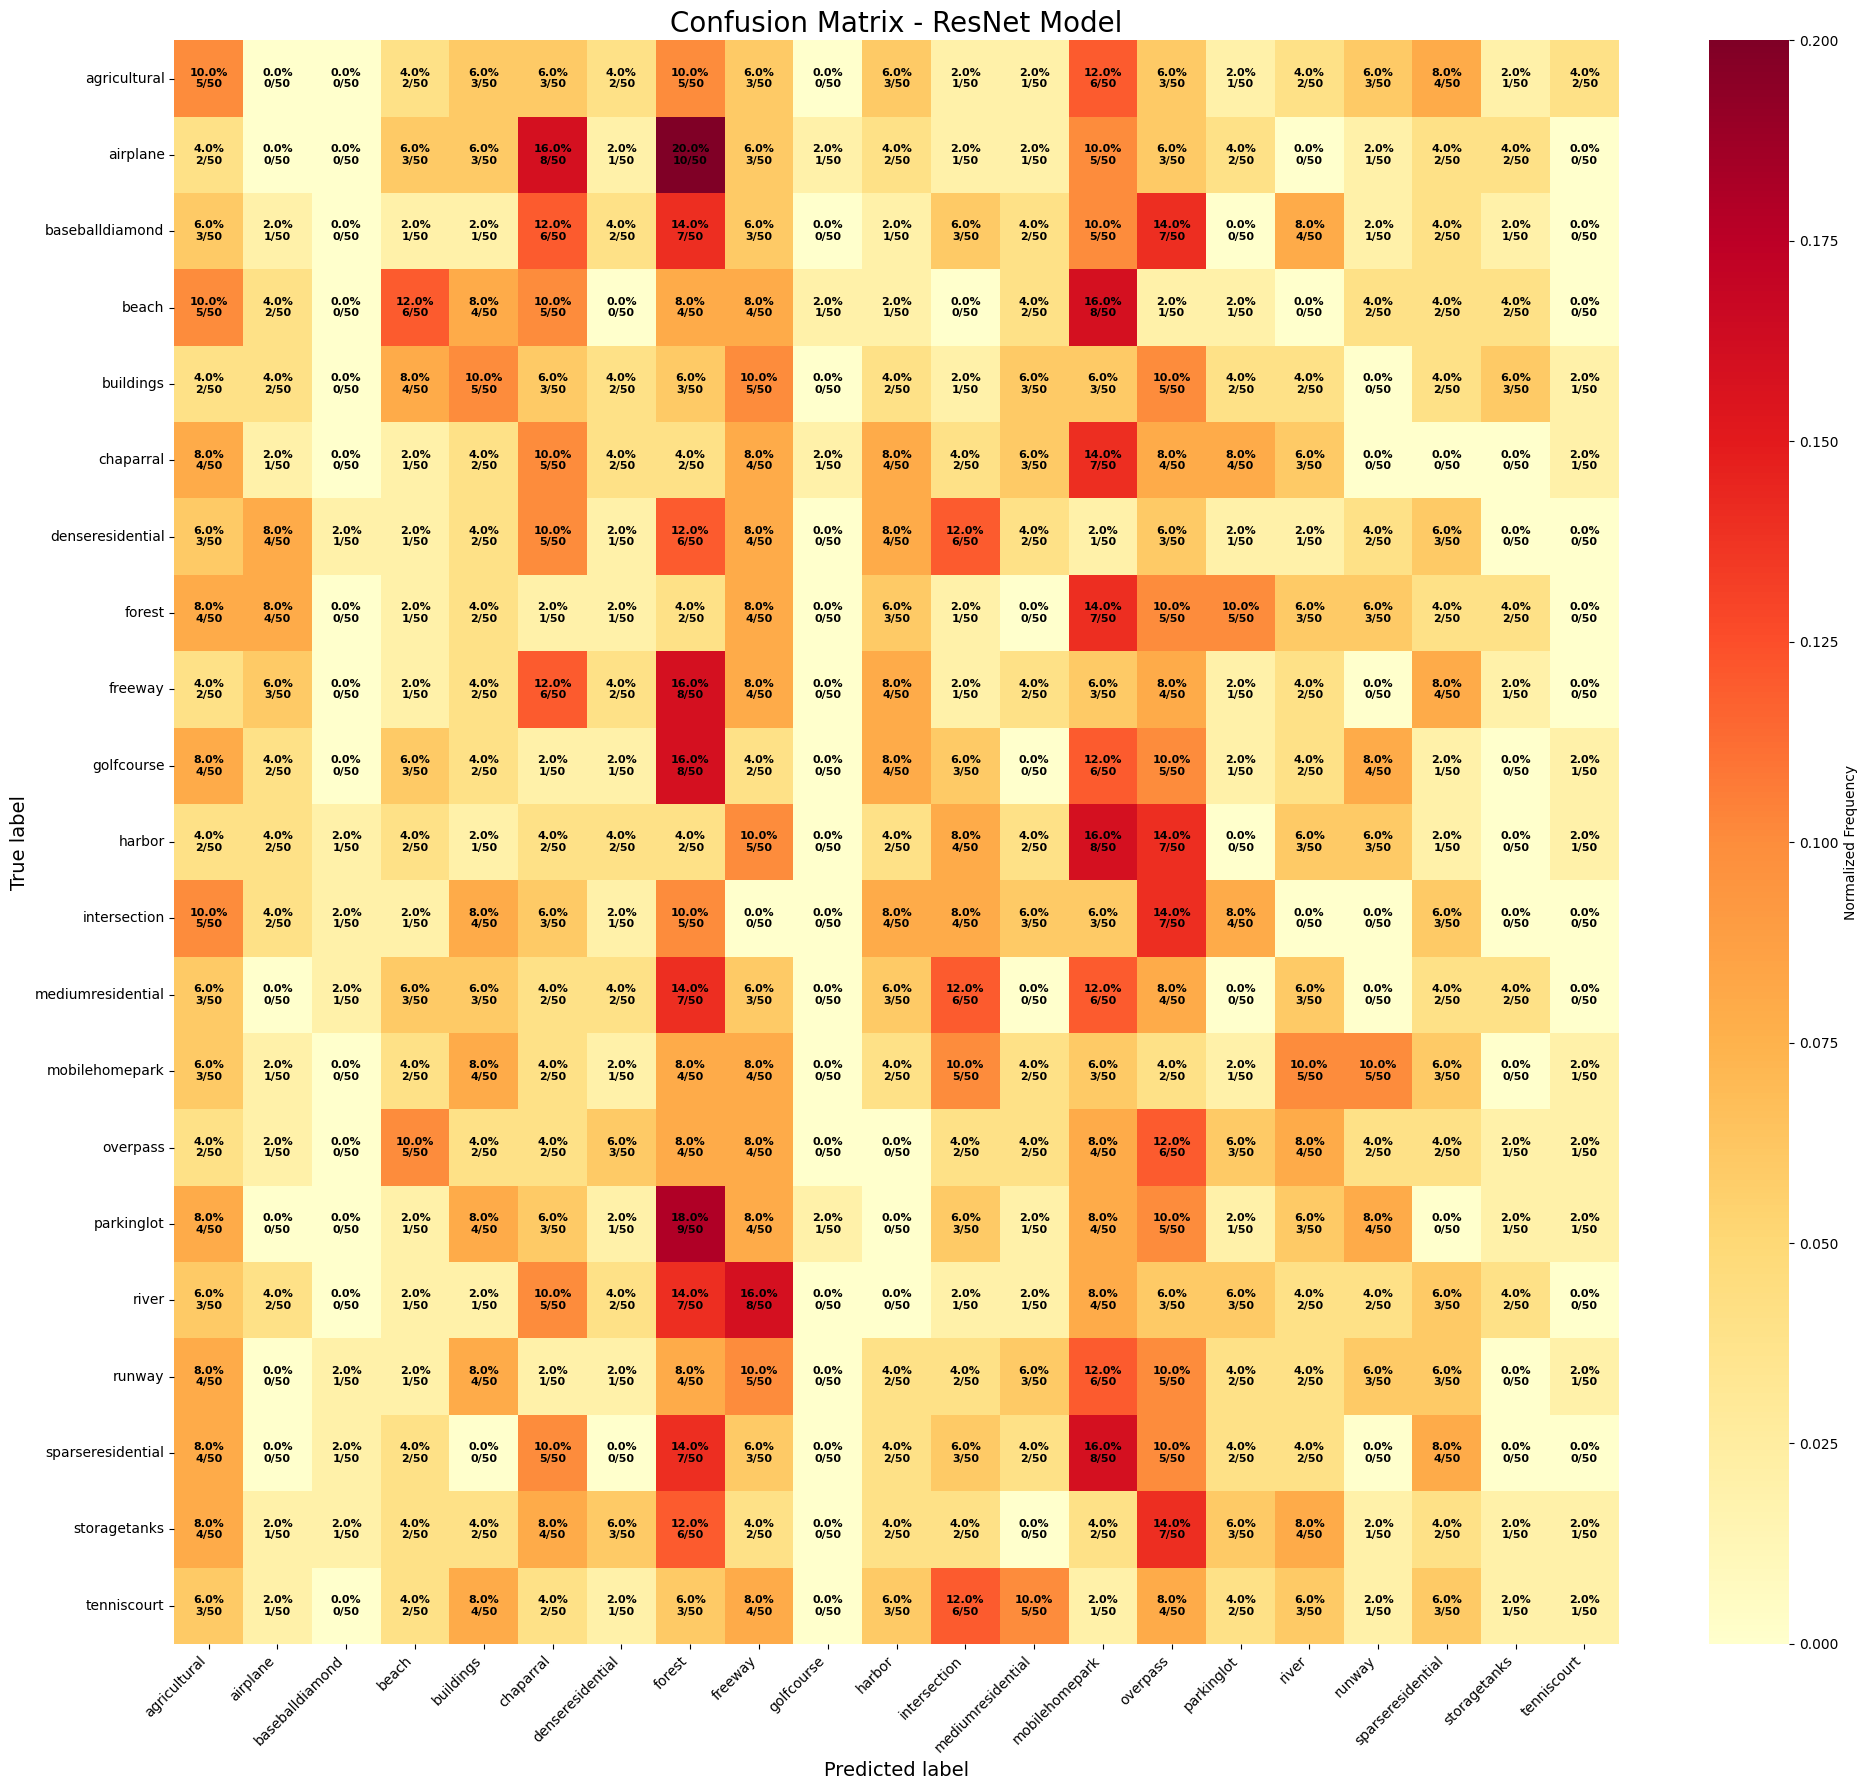

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model (assuming you've saved it during training)
model = load_model('models/best_HybridV2_model.keras')

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(20, 18))

# Plot the heatmap
sns.heatmap(cm_normalized, annot=False, cmap='YlOrRd', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Normalized Frequency'})

# Customize the plot
plt.title('Confusion Matrix - ResNet Model', fontsize=20)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add text annotations for percentages and absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f"{cm_normalized[i, j]:.1%}\n{cm[i, j]}/{cm[i, :].sum()}", 
                 ha="center", va="center", color="black" if cm_normalized[i, j] < 0.5 else "white", 
                 fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()